# ZRay Example for RT1 (Reference Notebook)

This notebook is a cleaned reference example for the `zray` package.

What this notebook covers:
- Load an axisymmetric vessel from a DXF file
- Visualize the vessel cross section and grid mask
- Configure cameras (`Camera2D_xyz`, `Camera2D_rphiz`, `LineCamera`)
- Run ray tracing and visualize the traced ray lengths


## Prerequisites

Recommended setup (from the repository root):

```bash
uv sync --dev
```

Notes:
- This notebook can be opened from either the repository root or the `sample/` directory.
- The notebook is stored without outputs so it stays lightweight and diff-friendly.


In [1]:
from pathlib import Path
import sys

import numpy as np
import matplotlib.pyplot as plt

# Resolve repository root whether the notebook is launched from repo root or sample/
cwd = Path.cwd().resolve()
if (cwd / "pyproject.toml").exists():
    REPO_ROOT = cwd
elif (cwd.parent / "pyproject.toml").exists():
    REPO_ROOT = cwd.parent
else:
    raise RuntimeError("Could not find repository root (pyproject.toml)")

SAMPLE_DIR = REPO_ROOT / "sample"
DXF_PATH = SAMPLE_DIR / "simplest0.dxf"
MODEL_JSON_PATH = SAMPLE_DIR / "model.json"

# Fallback for cases where the package is not installed into the current environment.
try:
    import zray
except ModuleNotFoundError:
    sys.path.insert(0, str(REPO_ROOT / "src"))
    import zray

plt.rcParams["figure.figsize"] = (6, 4)
print(f"Repository root: {REPO_ROOT}")
print(f"DXF path: {DXF_PATH}")


Repository root: C:\Users\ueda\github_project\ZRay
DXF path: C:\Users\ueda\github_project\ZRay\sample\simplest0.dxf


## 1. Load Vessel Geometry From DXF

`AxisymmetricVessel.load_from_dxf()` reads 2D R-Z cross-section geometry and stores it as line/arc/circle primitives.


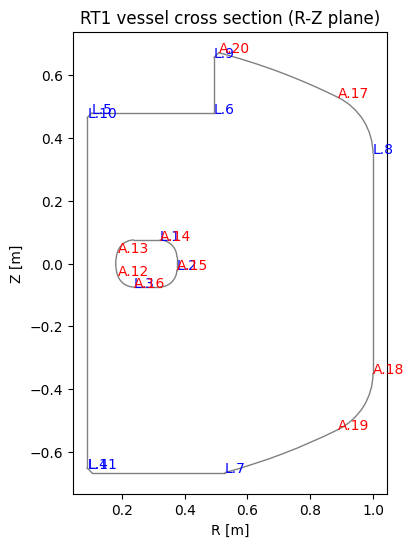

In [2]:
rt1_vessel = zray.AxisymmetricVessel.load_from_dxf(str(DXF_PATH))

fig, ax = plt.subplots(figsize=(6, 6))
rt1_vessel.plot(label=True, ax=ax)
ax.set_aspect("equal")
ax.set_title("RT1 vessel cross section (R-Z plane)")
ax.set_xlabel("R [m]")
ax.set_ylabel("Z [m]")
plt.show()


## 2. Generate a Vessel Grid Mask (Optional)

`detect_grid()` rasterizes the vessel boundary and flood-fills the interior region.
This is useful when creating reconstruction grids or masks.



fill_start_point is None, so use (np.float64(0.49999999999999994), np.float64(-3.700743415417188e-17))


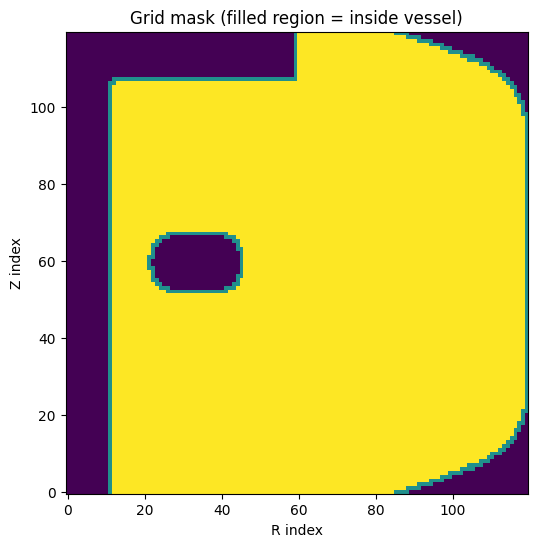

In [3]:
r_grid = np.linspace(0.0, 1.0, 120)
z_grid = np.linspace(-0.6, 0.6, 120)

rt1_vessel.detect_grid(r_grid, z_grid, static=True, isnt_print=True)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(rt1_vessel.fill, origin="lower", cmap="viridis")
ax.set_title("Grid mask (filled region = inside vessel)")
ax.set_xlabel("R index")
ax.set_ylabel("Z index")
plt.show()


## 3. Camera Configuration Examples

`zray` supports multiple camera models. This section shows representative configurations.


In [4]:
# 2D camera defined directly in Cartesian coordinates
camera_xyz = zray.measurement.Camera2D_xyz(
    focal_length=0.06,
    location=(4.0, 0.0, 1.6),
    direction=(-1.0, 0.0, -0.45),
    sensor_size=(0.036, 0.024),
    resolution=(300, 200),
    rotation=0.0,
)

# 2D camera defined in cylindrical-like camera parameters (r, phi, z + angles)
camera_rphiz = zray.measurement.Camera2D_rphiz(
    focal_length=0.0063,
    sensor_size=(0.004968, 0.00373),
    resolution=(300, 200),
    location=(1.18, 0.0, 0.0),
    center_angles=(23.601, -1.6),
    rotation=0.0,
)

pos_xyz, dir_xyz = camera_xyz.generate_ray()
pos_rphiz, dir_rphiz = camera_rphiz.generate_ray()
print("Camera2D_xyz rays:", pos_xyz.shape, dir_xyz.shape)
print("Camera2D_rphiz rays:", pos_rphiz.shape, dir_rphiz.shape)


focal_length: 0.0063
sensor_size: (0.004968, 0.00373)
resolution: (300, 200)
location: [1.18 0.   0.  ]
center_angles: (23.601, -1.6)
rotation: 0.0
im_shape: (200, 300)
_Camera2D_rphiz__M: 60000
Camera2D_xyz rays: (60000, 3) (60000, 3)
Camera2D_rphiz rays: (60000, 3) (60000, 3)


## 4. Ray Tracing With a 2D Camera

The `Raytracing` object computes ray intersections with the vessel geometry and (optionally) reflections.


In [5]:
model2d = zray.main.Raytracing(rt1_vessel, camera_xyz)
model2d.main(nreflections=3)
print(f"Number of ray sets (including reflections): {len(model2d.rays)}")


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


inf length is detected 19374


100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


inf length is detected 20728


100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


inf length is detected 20728


100%|██████████| 20/20 [00:42<00:00,  2.11s/it]

Number of ray sets (including reflections): 4


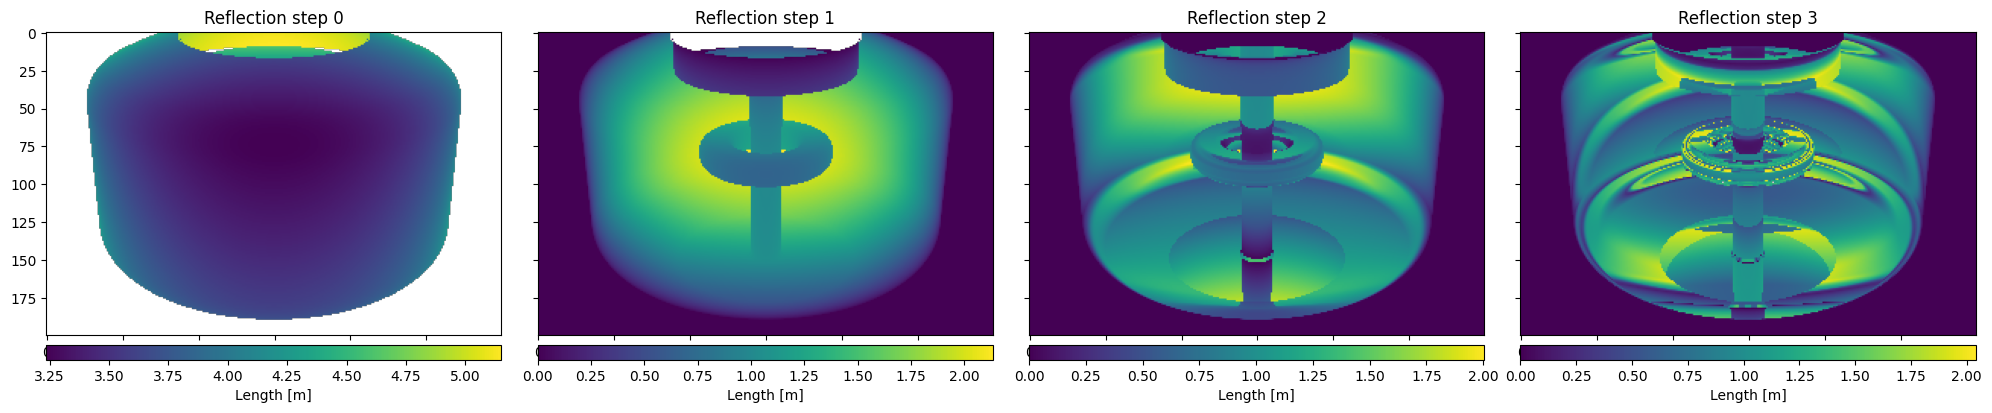

In [6]:
fig, axs = plt.subplots(1, len(model2d.rays), figsize=(5 * len(model2d.rays), 4), sharex=True, sharey=True)
if len(model2d.rays) == 1:
    axs = [axs]

for i, ray in enumerate(model2d.rays):
    zray.main.imshow_cbar_bottom(axs[i], ray.Length.im, cbar_title="Length [m]")
    axs[i].set_title(f"Reflection step {i}")

plt.tight_layout()
plt.show()


## 5. `LineCamera` + `MultiCamera` Example

Use `MultiCamera` when combining multiple 1D/2D sensors into one measurement set.


In [7]:
theta = np.arctan(0.45 / 1.0)

IF1 = zray.measurement.LineCamera(
    focal_length=0.06,
    location=(1.01, 0.0, 0.0),
    direction=(-np.cos(theta), np.sin(theta), 0.0),
    sensor_size=(0.01,),
    resolution=5,
)
IF2 = zray.measurement.LineCamera(
    focal_length=0.06,
    location=(0.75, 0.0, 0.8),
    direction=(0.0, 0.0, -1.0),
    sensor_size=(0.01,),
    resolution=5,
)
IF3 = zray.measurement.LineCamera(
    focal_length=0.06,
    location=(0.6, 0.0, 0.8),
    direction=(0.0, 0.0, -1.0),
    sensor_size=(0.01,),
    resolution=5,
)

multi_cam = zray.measurement.MultiCamera([IF1, IF2, IF3], name_list=["IF1", "IF2", "IF3"])
line_model = zray.main.Raytracing(rt1_vessel, multi_cam)
line_model.main(nreflections=1, pass_through_first=True)


['IF1', 'IF2', 'IF3']


100%|██████████| 20/20 [00:00<00:00, 8577.31it/s]


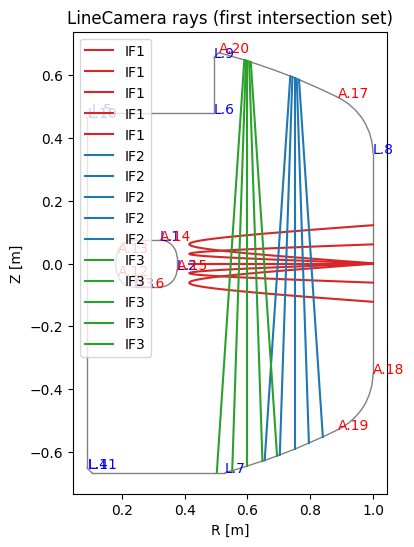

In [8]:
r, z = line_model.rays[1].generate_rz()

fig, ax = plt.subplots(figsize=(6, 6))
rt1_vessel.plot(label=True, ax=ax)

colors = {"IF1": "tab:red", "IF2": "tab:blue", "IF3": "tab:green"}
for name in multi_cam.name_list:
    sl = multi_cam.slice(name)
    ax.plot(r[sl, :].T, z[sl, :].T, color=colors[name], label=name)

ax.set_aspect("equal")
ax.set_xlabel("R [m]")
ax.set_ylabel("Z [m]")
ax.set_title("LineCamera rays (first intersection set)")
ax.legend()
plt.show()


## 5.1 Optional: 3D View of Vessel and Rays

This optional cell visualizes the axisymmetric vessel surface and the traced `LineCamera` rays in 3D.
It is useful for checking camera placement and ray directions.

Tip: If you want interactive rotation in Jupyter, you can try `%matplotlib widget` (requires `ipympl`).


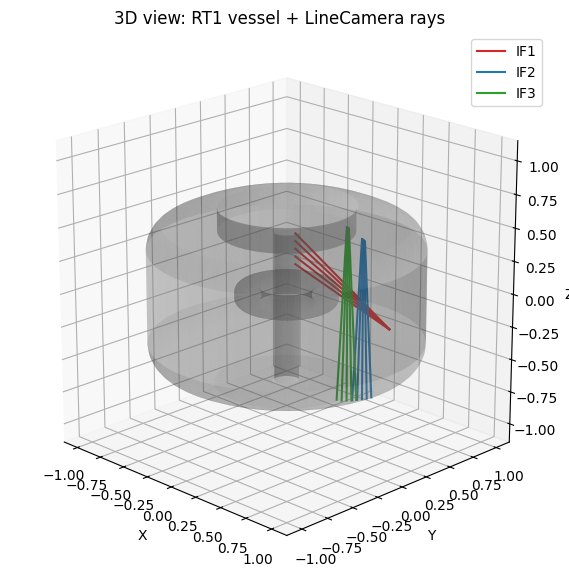

In [13]:
# Optional 3D visualization of the vessel and rays from the MultiCamera example
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

rt1_vessel.plot_3d_surface(
    ax=ax,
    start_angle=0,
    end_angle=360,
    num_points=50,
    color="gray",
    alpha=0.25,
)

x, y, z = line_model.rays[1].generate_xyz()
colors = {"IF1": "tab:red", "IF2": "tab:blue", "IF3": "tab:green"}

for name in multi_cam.name_list:
    sl = multi_cam.slice(name)
    ray_block = np.arange(line_model.rays[1].M)[sl]
    for j, idx in enumerate(ray_block):
        ax.plot3D(
            x[idx], y[idx], z[idx],
            color=colors[name],
            label=name if j == 0 else None,
        )

ax.view_init(elev=20, azim=-45)
ax.set_title("3D view: RT1 vessel + LineCamera rays")
ax.set_aspect("equal")
ax.legend()
plt.show()


## 6. Save / Load Settings (Optional)

Use JSON for light-weight configuration sharing, and pickle for a heavier snapshot.
The lines below are intentionally commented out to avoid writing files when the notebook is run as a reference.


In [10]:
# Save a portable JSON configuration
# model2d.save_setting(str(MODEL_JSON_PATH))

# Load from JSON or pickle
# reloaded = zray.main.Raytracing.load(str(MODEL_JSON_PATH))
# print(type(reloaded), len(reloaded.container.Curves))

# Heavy snapshot (pickle; less portable across versions)
# model2d.save_heavy_model(str(SAMPLE_DIR / "heavy_model"))
